In [10]:
import os
from typing import List, Dict
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import lightgbm as lgb
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
# 파일 호출
data_path: str = "../data"
train_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "train.csv")).assign(_type="train") # train 에는 _type = train 
test_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")).assign(_type="test") # test 에는 _type = test
submission_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")) # ID, target 열만 가진 데이터 미리 호출
df: pd.DataFrame = pd.concat([train_df, test_df], axis=0)

In [12]:
# HOURLY_ 로 시작하는 .csv 파일 이름을 file_names 에 할딩
file_names: List[str] = [
    f for f in os.listdir(data_path) if f.startswith("HOURLY_") and f.endswith(".csv")
]

# 파일명 : 데이터프레임으로 딕셔너리 형태로 저장
file_dict: Dict[str, pd.DataFrame] = {
    f.replace(".csv", ""): pd.read_csv(os.path.join(data_path, f)) for f in file_names
}

for _file_name, _df in tqdm(file_dict.items()):
    # 열 이름 중복 방지를 위해 {_file_name.lower()}_{col.lower()}로 변경, datetime 열을 ID로 변경
    _rename_rule = {
        col: f"{_file_name.lower()}_{col.lower()}" if col != "datetime" else "ID"
        for col in _df.columns
    }
    _df = _df.rename(_rename_rule, axis=1)
    df = df.merge(_df, on="ID", how="left")

100%|██████████| 107/107 [00:02<00:00, 37.50it/s]


In [13]:
# missing value check

train_df = df.loc[df["_type"] == "train"]
# 각 열에서 누락된 값의 수 & 백분율 계산
missing_values = train_df.isnull().sum()
missing_percentage = (missing_values / len(train_df)) * 100

# 누락된 값 비율을 기준으로 열 정렬
sorted_missing_percentage = missing_percentage.sort_values(ascending=False)

# missing_value의 비율이 100%가 아닌 column만 추출
non_missing_columns = sorted_missing_percentage[sorted_missing_percentage != 100.0].index.tolist()
non_missing_columns.remove('ID')
non_missing_columns.remove('target')
non_missing_columns.remove('_type')


In [14]:
new_data = train_df[['ID','target', '_type'] + non_missing_columns]

In [15]:
columns_with_100_missing = sorted_missing_percentage[sorted_missing_percentage == 100]
print(columns_with_100_missing)
print(len(columns_with_100_missing))

hourly_market-data_liquidations_ftx_all_symbol_long_liquidations          100.0
hourly_market-data_liquidations_okex_btc_usd_short_liquidations_usd       100.0
hourly_market-data_open-interest_ftx_open_interest                        100.0
hourly_market-data_open-interest_huobi_global_open_interest               100.0
hourly_market-data_funding-rates_okex_funding_rates                       100.0
hourly_market-data_open-interest_okx_open_interest                        100.0
hourly_market-data_liquidations_okex_btc_usd_long_liquidations            100.0
hourly_market-data_liquidations_okex_btc_usd_short_liquidations           100.0
hourly_market-data_open-interest_okex_open_interest                       100.0
hourly_market-data_open-interest_kraken_open_interest                     100.0
hourly_market-data_open-interest_deribit_open_interest                    100.0
hourly_market-data_open-interest_ftx_btc_usd_open_interest                100.0
hourly_market-data_open-interest_binance

In [16]:
# 이동평균으로 결측치 대체
new_df_stab = new_data[non_missing_columns]

# train
window_size = 3
new_df_stab = new_df_stab.apply(lambda col: col.fillna(col.rolling(window=window_size, min_periods=1).mean()))
new_df_stab = new_df_stab.fillna(method='ffill').fillna(method='bfill')


# 결측치 처리한 new_df 정의
new_train_df = pd.concat([new_data[['ID','target','_type']], new_df_stab], axis=1)

/tmp/ipykernel_311322/2767777812.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  new_df_stab = new_df_stab.fillna(method='ffill').fillna(method='bfill')


In [17]:
# nan or inf 데이터 여부 확인
for col in non_missing_columns:
    if (np.isnan(new_train_df[col]).any()) | (np.isinf(new_train_df[col]).any()):
        print(col)
        break

In [18]:
test_df = df.loc[df["_type"] == "test"]
new_test_df = test_df[['ID','target','_type'] + non_missing_columns]

new_test_stab = new_test_df[non_missing_columns]
# test
window_size = 3
new_test_stab = new_test_stab.apply(lambda col: col.fillna(col.rolling(window=window_size, min_periods=1).mean()))
new_test_stab = new_test_stab.fillna(method='ffill')

new_test_df = pd.concat([new_test_df[['ID','target','_type']], new_test_stab], axis=1)

/tmp/ipykernel_311322/3218535113.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  new_test_stab = new_test_stab.fillna(method='ffill')


In [19]:
# 결측치 비율을 계산
missing_percentage = new_test_df.isnull().mean() * 100

# 결측치 비율이 100%인 컬럼 이름만 출력
columns_with_all_missing = missing_percentage[missing_percentage >= 50].index.tolist()

# 100% 결측치가 있는 컬럼 출력
columns_with_all_missing = [col for col in columns_with_all_missing if col not in ['target', 'hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close']]
columns_with_all_missing

['hourly_market-data_liquidations_binance_btc_busd_short_liquidations',
 'hourly_market-data_liquidations_binance_btc_busd_long_liquidations_usd',
 'hourly_market-data_liquidations_binance_btc_busd_long_liquidations',
 'hourly_market-data_liquidations_binance_btc_busd_short_liquidations_usd',
 'hourly_market-data_open-interest_binance_btc_busd_open_interest',
 'hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_volume']

In [20]:
# train_df와 test_df에서 columns_with_all_missing에 있는 컬럼 삭제
new_train_df = new_train_df.drop(columns=columns_with_all_missing, errors='ignore')
new_test_df = new_test_df.drop(columns=columns_with_all_missing, errors='ignore')

In [21]:
# 이동평균을 기반으로 이상치를 처리하는 함수
def replace_outlier(df, window=3, threshold=2):
    df_cleaned = df.copy()
    
    # 숫자형 컬럼들에 대해 처리
    for column in df_cleaned.select_dtypes(include=[np.number]).columns:
        # 이동평균과 표준편차 계산
        rolling_mean = df_cleaned[column].rolling(window=window, min_periods=1).mean()
        rolling_std = df_cleaned[column].rolling(window=window, min_periods=1).std()

        # 이상치 기준 설정
        outliers = np.abs(df_cleaned[column] - rolling_mean) > (threshold * rolling_std)

        # 이상치를 이동평균으로 대체
        df_cleaned.loc[outliers, column] = rolling_mean[outliers]
    
    return df_cleaned

# 이동평균 기반 이상치 처리 적용
cleaned_train_df = replace_outlier(new_train_df)
cleaned_test_df = replace_outlier(new_test_df)

In [26]:
# Standardization으로 정규화
from sklearn.preprocessing import StandardScaler

def standardization(train_df, test_df):
    features_to_scale = [col for col in train_df.columns if col not in ['ID', 'target', '_type']]

    scaler = StandardScaler()

    # 훈련 데이터 정규화
    train_df_scaled = train_df.copy()
    train_df_scaled[features_to_scale] = scaler.fit_transform(train_df[features_to_scale])

    # 테스트 데이터 정규화
    test_df_scaled = test_df.copy()
    test_df_scaled[features_to_scale] = scaler.transform(test_df[features_to_scale])

    return train_df_scaled, test_df_scaled

# 함수 호출
std_train_df, std_test_df = standardization(cleaned_train_df, cleaned_test_df)

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# 타겟과 피처 설정
y_train = std_train_df['hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close']
X_train = std_train_df.drop(columns=['hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close', 'ID', 'target', '_type'], errors='ignore')

# 훈련 데이터와 검증 데이터 나누기
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# 모델 훈련
model = RandomForestRegressor()
model.fit(X_train_split, y_train_split)

# 검증 데이터에서 예측
y_val_pred = model.predict(X_val)

# 성능 평가
mse = mean_squared_error(y_val, y_val_pred)
print("Mean Squared Error on Validation Set:", mse)

# 모델 훈련
model = RandomForestRegressor()
model.fit(X_train, y_train)

# test_df에서 예측
X_test = std_test_df.drop(columns=['hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close', 'ID', 'target', '_type'], errors='ignore')
y_pred = model.predict(X_test)

# new_test_df에 y_pred 값을 추가
std_test_df['hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close'] = y_pred

# 결과 확인
std_test_df.head()

Mean Squared Error on Validation Set: 0.0006345718891465544


,ID,target,_type,hourly_market-data_funding-rates_bybit_funding_rates,hourly_market-data_taker-buy-sell-stats_bybit_taker_sell_ratio,hourly_market-data_taker-buy-sell-stats_bybit_taker_buy_sell_ratio,hourly_market-data_taker-buy-sell-stats_bybit_taker_buy_ratio,hourly_market-data_taker-buy-sell-stats_bybit_taker_sell_volume,hourly_market-data_taker-buy-sell-stats_bybit_taker_buy_volume,hourly_network-data_fees_fees_reward_percent,...,hourly_network-data_addresses-count_addresses_count_sender,hourly_network-data_addresses-count_addresses_count_receiver,hourly_network-data_block-count_block_count,hourly_network-data_fees_fees_total,hourly_network-data_fees_fees_total_usd,hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close,hourly_market-data_liquidations_htx_global_btc_usd_short_liquidations,hourly_market-data_liquidations_htx_global_btc_usd_long_liquidations_usd,hourly_market-data_liquidations_htx_global_btc_usd_short_liquidations_usd,hourly_network-data_utxo-count_utxo_count
8760,2024-01-01 00:00:00,NaN,test,0.862267,-1.106685,0.628514,1.123435,-0.368791,0.047456,3.380109,...,-0.333541,-1.275562,-0.846352,1.945012,2.242378,2.303017,-0.048054,-0.099003,-0.052688,2.198334
8761,2024-01-01 01:00:00,NaN,test,1.129189,-1.186934,0.709193,1.203588,-0.359145,0.106802,2.357192,...,2.749899,-0.856214,1.958204,4.171627,4.675388,2.306272,-0.048054,-0.099003,-0.052688,2.199442
8762,2024-01-01 02:00:00,NaN,test,1.435859,0.022434,-0.173300,-0.004335,-0.671636,-0.671125,2.202971,...,0.872912,-0.958328,0.355601,2.247406,2.580664,2.299326,-0.048054,-0.099003,-0.052688,2.200676
8763,2024-01-01 03:00:00,NaN,test,1.686091,1.514450,-0.737805,-1.494569,0.141968,-0.415430,2.127932,...,0.519154,-1.844483,-0.045050,1.763478,2.048809,2.293478,-0.048054,-0.099003,-0.052688,2.201494
8764,2024-01-01 04:00:00,NaN,test,1.702782,-2.809388,4.499324,2.824104,-0.606351,0.773042,2.205002,...,1.394110,-1.329516,0.756251,2.656814,3.007544,2.294470,-0.048054,-0.099003,-0.052688,2.202644


In [28]:
df = pd.concat([std_train_df, std_test_df], ignore_index=True)
df.head()

,ID,target,_type,hourly_market-data_funding-rates_bybit_funding_rates,hourly_market-data_taker-buy-sell-stats_bybit_taker_sell_ratio,hourly_market-data_taker-buy-sell-stats_bybit_taker_buy_sell_ratio,hourly_market-data_taker-buy-sell-stats_bybit_taker_buy_ratio,hourly_market-data_taker-buy-sell-stats_bybit_taker_sell_volume,hourly_market-data_taker-buy-sell-stats_bybit_taker_buy_volume,hourly_network-data_fees_fees_reward_percent,...,hourly_network-data_addresses-count_addresses_count_sender,hourly_network-data_addresses-count_addresses_count_receiver,hourly_network-data_block-count_block_count,hourly_network-data_fees_fees_total,hourly_network-data_fees_fees_total_usd,hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close,hourly_market-data_liquidations_htx_global_btc_usd_short_liquidations,hourly_market-data_liquidations_htx_global_btc_usd_long_liquidations_usd,hourly_market-data_liquidations_htx_global_btc_usd_short_liquidations_usd,hourly_network-data_utxo-count_utxo_count
0,2023-01-01 00:00:00,2.0,train,0.242277,-0.660030,0.248331,0.677313,-0.790786,-0.739005,-0.725213,...,0.364113,0.946969,2.358855,-0.472265,-0.467622,-2.083215,-0.048054,-0.099003,-0.052688,-1.216481
1,2023-01-01 01:00:00,1.0,train,0.242277,-2.214769,2.351257,2.230195,-0.812900,-0.555248,-0.688410,...,-1.394462,-0.773384,-0.846352,-0.540988,-0.496686,-2.079750,-0.048054,-0.099003,-0.052688,-1.216149
2,2023-01-01 02:00:00,1.0,train,0.242277,1.204924,-0.646820,-1.185413,-0.783052,-0.844533,-0.741502,...,-1.014429,-0.889786,0.756251,-0.528197,-0.491262,-2.081277,-0.048054,-0.099003,-0.052688,-1.216188
3,2023-01-01 03:00:00,1.0,train,0.242277,-0.654333,0.244119,0.671624,-0.841254,-0.809874,-0.731158,...,-1.459339,-0.447158,-0.445701,-0.549200,-0.500178,-2.083744,-0.048054,-0.099003,-0.052688,-1.215593
4,2023-01-01 04:00:00,2.0,train,0.242277,0.388268,-0.346476,-0.369732,-0.660023,-0.701877,-0.719856,...,-1.043804,0.343477,0.355601,-0.521007,-0.488245,-2.085260,-0.048054,-0.099003,-0.052688,-1.214962


In [29]:
# 모델에 사용할 컬럼, 컬럼의 rename rule을 미리 할당함
cols_dict: Dict[str, str] = {
    "ID": "ID",
    "target": "target",
    "_type": "_type",
    "hourly_market-data_funding-rates_all_exchange_funding_rates": "funding_rates",
    "hourly_network-data_difficulty_difficulty" : "difficulty",
    "hourly_market-data_open-interest_all_exchange_all_symbol_open_interest" : "open_interest",
    "hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations": "long_liquidations",
    #"hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations_usd": "long_liquidations_usd",
    "hourly_market-data_liquidations_all_exchange_all_symbol_short_liquidations": "short_liquidations",
    #"hourly_market-data_liquidations_all_exchange_all_symbol_short_liquidations_usd": "short_liquidations_usd",
    #"hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_ratio": "buy_ratio",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_volume": "buy_volume",
    #"hourly_market-data_taker-buy-sell-stats_all_exchange_taker_sell_ratio": "sell_ratio",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_sell_volume": "sell_volume",
    #"hourly_network-data_addresses-count_addresses_count_active": "active_count",
    #"hourly_network-data_addresses-count_addresses_count_receiver": "receiver_count",
    #"hourly_network-data_addresses-count_addresses_count_sender": "sender_count",
    "hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close" : "close",
}
df = df[cols_dict.keys()].rename(cols_dict, axis=1)
df.shape

(11552, 11)

In [30]:
# eda 에서 파악한 차이와 차이의 음수, 양수 여부를 새로운 피쳐로 생성
df = df.assign(
    #liquidation_diff=df["long_liquidations"] - df["short_liquidations"],
    #liquidation_usd_diff=df["long_liquidations_usd"] - df["short_liquidations_usd"],
    volume_diff=df["buy_volume"] - df["sell_volume"],
    buy_sell_volume_ratio=df["buy_volume"] / (df["sell_volume"] + 1),
    close_diff = df['close'].diff().fillna(0),
    volume = df["buy_volume"] + df["sell_volume"]
)
# category, continuous 열을 따로 할당해둠
conti_cols: List[str] = [_ for _ in cols_dict.values() if _ not in ["ID", "target", "_type"]] + [
    #"liquidation_diff",
    #"liquidation_usd_diff",
    "volume_diff",
    "buy_sell_volume_ratio",
    "close_diff",
    "volume"
]

In [167]:
eda_df = df.loc[df["_type"]=="train"]
print(eda_df.shape)
eda_df["target"].value_counts()/len(eda_df)

(8760, 10)


target
2.0    0.419064
1.0    0.404566
3.0    0.091895
0.0    0.084475
Name: count, dtype: float64

변수간 상관관계

<Axes: >

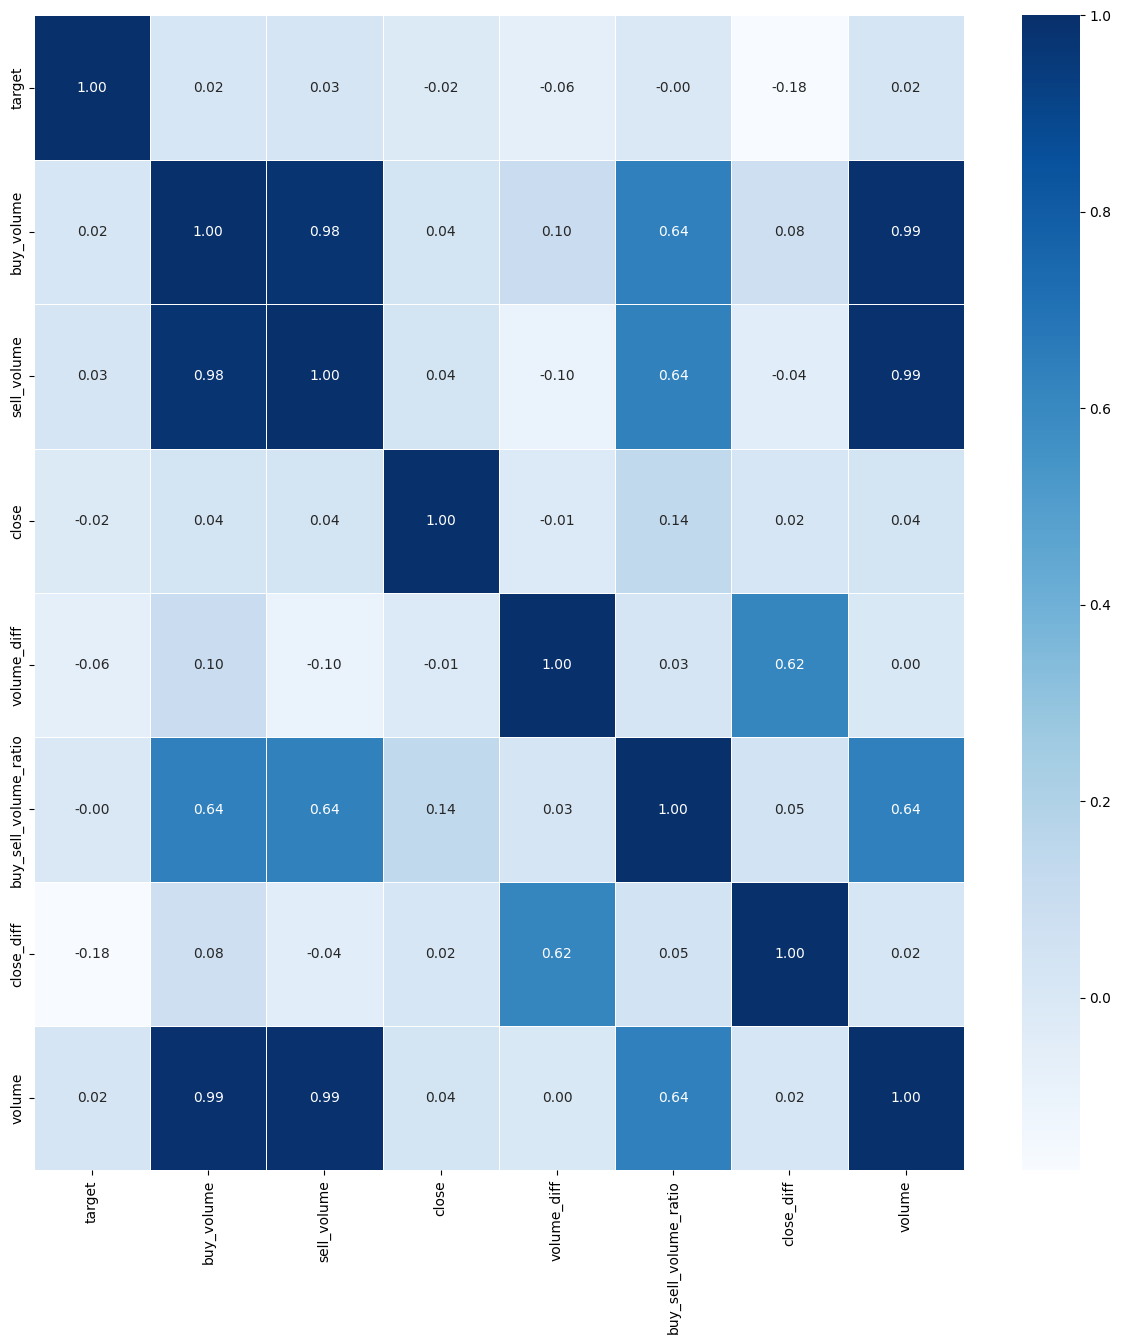

In [149]:
corr_df = eda_df.drop(columns=["_type", "ID"])
plt.figure(figsize=(15,15))
sns.heatmap(data = corr_df.corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Blues')

In [27]:
bar_df = eda_df.groupby("target").agg({
    "liquidation_diff" : "mean",
    "liquidation_usd_diff" : "mean",
    "close" : "mean",
    "volume_diff" : "mean",
    "close_diff" : "mean",
    "volume" : "mean",
}).reset_index()
bar_df

,target,liquidation_diff,liquidation_usd_diff,close,volume_diff,close_diff,volume
0,0.0,-0.037652,-0.048132,0.143783,0.006109,0.012732,0.838378
1,1.0,-0.046976,-0.052222,-0.018169,0.017566,0.003201,-0.205267
2,2.0,0.037979,0.046941,-0.022743,-0.014028,-0.001804,-0.196395
3,3.0,0.068227,0.060087,0.051531,-0.018980,-0.012137,1.028610


In [28]:
fig: go.Figure = make_subplots(
    rows = 3,
    cols = 2,
    shared_xaxes = True,
    subplot_titles=(
        "liquidation_diff",
        "liquidation_usd_diff",
        "close",
        "volume_diff",
        "close_diff",
        "volume",
    )
)
fig.add_trace(go.Bar(x=bar_df["target"], y=bar_df["liquidation_diff"]), row=1,col=1)
fig.add_trace(go.Bar(x=bar_df["target"], y=bar_df["liquidation_usd_diff"]), row=1,col=2)
fig.add_trace(go.Bar(x=bar_df["target"], y=bar_df["close"]), row=2,col=1)
fig.add_trace(go.Bar(x=bar_df["target"], y=bar_df["volume_diff"]), row=2,col=2)
fig.add_trace(go.Bar(x=bar_df["target"], y=bar_df["close_diff"]), row=3,col=1)
fig.add_trace(go.Bar(x=bar_df["target"], y=bar_df["volume"]), row=3,col=2)
fig.update_layout(title_text="Target statistics", showlegend=False)
fig.update_xaxes(title_text="Target", row=3)
fig.show()

In [31]:
def shift_feature(
    df: pd.DataFrame,
    conti_cols: List[str],
    intervals: List[int],
) -> List[pd.Series]:
    """
    연속형 변수의 shift feature 생성
    Args:
        df (pd.DataFrame)
        conti_cols (List[str]): continuous colnames
        intervals (List[int]): shifted intervals
    Return:
        List[pd.Series]
    """
    df_shift_dict = [
        df[conti_col].shift(interval).rename(f"{conti_col}_{interval}")
        for conti_col in conti_cols
        for interval in intervals
    ]
    return df_shift_dict

# 최대 24시간의 shift 피쳐를 계산
shift_list = shift_feature(
    df=df, conti_cols=conti_cols, intervals=[_ for _ in range(1, 24)]
)

In [32]:
# concat 하여 df 에 할당
df = pd.concat([df, pd.concat(shift_list, axis=1)], axis=1)

# 타겟 변수를 제외한 변수를 forwardfill, -999로 결측치 대체
_target = df["target"]
df = df.ffill().fillna(-999).assign(target = _target)

# _type에 따라 train, test 분리
train_df = df.loc[df["_type"]=="train"].drop(columns=["_type"])
test_df = df.loc[df["_type"]=="test"].drop(columns=["_type"])


BlockingTimeSeriesSplit 교차검증

In [174]:
import xgboost as xgb

class BlockingTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits
    
    def get_n_splits(self, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)
    
        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.8 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]

btscv = BlockingTimeSeriesSplit(n_splits=5)
x_train_full = train_df.drop(["target", "ID"], axis = 1)
y_train_full = train_df["target"].astype(int)

# 클래스 가중치 설정
class_weights = {0: 4.0, 1: 1.0, 2: 1.0, 3: 4.0}

params = {
    "boosting_type": "gbdt",
    "objective": "multiclass",
    "metric": "multi_logloss",
    "num_class": 4,
    "num_leaves": 50,
    "learning_rate": 0.1,
    "n_estimators": 30,
    "random_state": 42,
    "verbose": 0,
    "is_unbalance": True,
}

# 여러 분할에 대해 모델 평가
accuracies = []
aurocs = []

for train_index, valid_index in btscv.split(x_train_full):
    x_train, x_valid = x_train_full.iloc[train_index], x_train_full.iloc[valid_index]
    y_train, y_valid = y_train_full.iloc[train_index], y_train_full.iloc[valid_index]
    
    # lgb dataset
    train_data = lgb.Dataset(x_train, label=y_train, weight=[class_weights[y] for y in y_train])
    valid_data = lgb.Dataset(x_valid, label=y_valid, reference=train_data)
    
    # lgb train
    lgb_model = lgb.train(
        params=params,
        train_set=train_data,
        valid_sets=valid_data
    )

    # XGBoost dataset
    train_data_xgb = xgb.DMatrix(x_train, label=y_train)
    valid_data_xgb = xgb.DMatrix(x_valid, label=y_valid)
    
    # XGBoost params
    params_xgb = {
        "objective": "multi:softprob",
        "num_class": 4,
        "eval_metric": "mlogloss",
        "eta": 0.1,
        "max_depth": 6,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "seed": 42,
    }
    
    # XGBoost train
    xgb_model = xgb.train(
        params=params_xgb,
        dtrain=train_data_xgb,
        num_boost_round=30,
        evals=[(valid_data_xgb, 'eval')],
        verbose_eval=False
    )
    
    y_valid_pred_lgb = lgb_model.predict(x_valid)
    y_valid_pred_xgb = xgb_model.predict(valid_data_xgb)

    y_valid_pred_ensemble = (y_valid_pred_lgb + y_valid_pred_xgb) / 2
    
    y_valid_pred_class_ensemble = np.argmax(y_valid_pred_ensemble, axis=1)
    
    accuracy = accuracy_score(y_valid, y_valid_pred_class_ensemble)
    auroc = roc_auc_score(y_valid, y_valid_pred_ensemble, multi_class="ovr")
    
    accuracies.append(accuracy)
    aurocs.append(auroc)

print(f"Mean accuracy: {np.mean(accuracies)}, Mean AUROC: {np.mean(aurocs)}")

/data/ephemeral/home/myenv/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning:

Found `n_estimators` in params. Will use it instead of argument



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/data/ephemeral/home/myenv/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning:

Found `n_estimators` in params. Will use it instead of argument



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/data/ephemeral/home/myenv/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning:

Found `n_estimators` in params. Will use it instead of argument



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/data/ephemeral/home/myenv/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning:

Found `n_estimators` in params. Will use it instead of argument



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/data/ephemeral/home/myenv/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning:

Found `n_estimators` in params. Will use it instead of argument



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Mean accuracy: 0.3851851851851852, Mean AUROC: 0.5782241153224245


LGBM split

In [33]:
# train_test_split 으로 valid set, train set 분리
x_train, x_valid, y_train, y_valid = train_test_split(
    train_df.drop(["target", "ID"], axis = 1), 
    train_df["target"].astype(int), 
    test_size=0.2,
    random_state=42,
)

# lgb dataset
train_data = lgb.Dataset(x_train, label=y_train)
valid_data = lgb.Dataset(x_valid, label=y_valid, reference=train_data)

# lgb params
params = {
    "boosting_type": "gbdt",
    "objective": "multiclass",
    "metric": "multi_logloss",
    "num_class": 4,
    "num_leaves": 50,
    "learning_rate": 0.05,
    "n_estimators": 30,
    "random_state": 42,
    "verbose": 0,
}

# lgb train
lgb_model = lgb.train(
    params=params,
    train_set=train_data,
    valid_sets=valid_data,
)

# lgb predict
y_valid_pred = lgb_model.predict(x_valid)
y_valid_pred_class = np.argmax(y_valid_pred, axis = 1)

# score check
accuracy = accuracy_score(y_valid, y_valid_pred_class)
auroc = roc_auc_score(y_valid, y_valid_pred, multi_class="ovr")

print(f"acc: {accuracy}, auroc: {auroc}")

/data/ephemeral/home/myenv/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


acc: 0.4646118721461187, auroc: 0.6551947874904951


In [161]:
x_train = train_df.drop(["target", "ID"], axis = 1)
y_train = train_df["target"].astype(int)

# LightGBM 전체 데이터로 재학습
train_data_lgb = lgb.Dataset(x_train, label=y_train)
lgb_model = lgb.train(
    params=params,
    train_set=train_data_lgb
)

# XGBoost 전체 데이터로 재학습
train_data_xgb = xgb.DMatrix(x_train, label=y_train)
xgb_model = xgb.train(
    params=params_xgb,
    dtrain=train_data_xgb,
    num_boost_round=30
)

# 테스트 데이터 예측
y_test_pred_lgb = lgb_model.predict(test_df.drop(["target", "ID"], axis = 1))
y_test_pred_xgb = xgb_model.predict(xgb.DMatrix(test_df.drop(["target", "ID"], axis = 1)))

# 앙상블 예측 (평균)
y_test_pred_ensemble = (y_test_pred_lgb + y_test_pred_xgb) / 2

# 클래스 예측
y_test_pred_class_ensemble = np.argmax(y_test_pred_ensemble, axis=1)

# 각 클래스의 개수 출력
class_counts = np.bincount(y_test_pred_class_ensemble, minlength=4)
for i, count in enumerate(class_counts):
    print(f"Class {i}: {count} instances")

/data/ephemeral/home/myenv/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning:

Found `n_estimators` in params. Will use it instead of argument



Class 0: 6 instances
Class 1: 1173 instances
Class 2: 1599 instances
Class 3: 14 instances


In [34]:
# performance 체크후 전체 학습 데이터로 다시 재학습
x_train = train_df.drop(["target", "ID"], axis = 1)
y_train = train_df["target"].astype(int)
train_data = lgb.Dataset(x_train, label=y_train)
lgb_model = lgb.train(
    params=params,
    train_set=train_data,
)

/data/ephemeral/home/myenv/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [35]:
# lgb predict
y_test_pred = lgb_model.predict(test_df.drop(["target", "ID"], axis = 1))
y_test_pred_class = np.argmax(y_test_pred, axis = 1)

In [36]:
import shap

X_test = test_df.drop(["target", "ID"], axis=1)
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(X_test)
mean_abs_shap_values = np.mean(np.abs(shap_values), axis=0).mean(axis=1)

# 중요도 정렬을 위한 DataFrame 생성
shap_importance = pd.DataFrame({
    'feature': X_test.columns,
    'importance': mean_abs_shap_values
})

# 중요도 정렬
shap_importance = shap_importance.sort_values(by='importance', ascending=False)

# 결과 출력
print(shap_importance.head(60))

/data/ephemeral/home/myenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


                      feature  importance
10                 close_diff    0.095108
6                 sell_volume    0.061294
5                  buy_volume    0.040728
150             sell_volume_1    0.030556
9       buy_sell_volume_ratio    0.026995
107      short_liquidations_4    0.013211
11                     volume    0.012996
196             volume_diff_1    0.011900
216            volume_diff_21    0.011521
242              close_diff_1    0.010995
82        long_liquidations_2    0.010609
3           long_liquidations    0.010509
201             volume_diff_6    0.010044
262             close_diff_21    0.009953
8                 volume_diff    0.009749
101      long_liquidations_21    0.009374
105      short_liquidations_2    0.008514
206            volume_diff_11    0.008339
147             buy_volume_21    0.008332
131              buy_volume_5    0.008239
104      short_liquidations_1    0.008064
180                   close_8    0.007808
4          short_liquidations    0

In [37]:
# output file 할당후 save 
submission_df = submission_df.assign(target = y_test_pred_class)
submission_df.to_csv("output_close.csv", index=False)

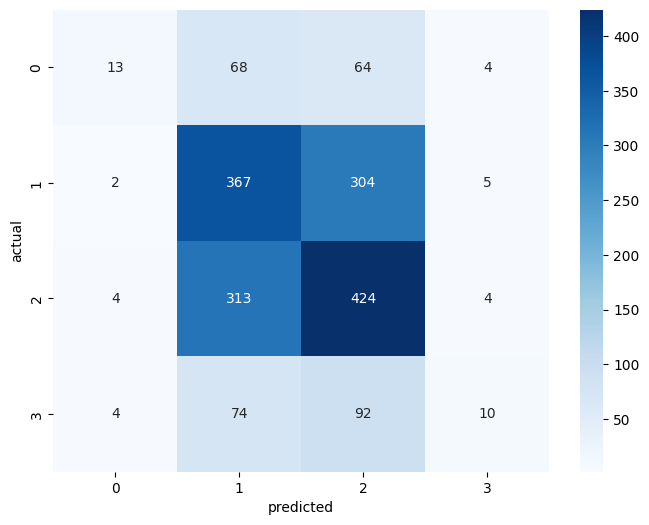

In [38]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_valid, y_valid_pred_class)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt='d', xticklabels=[0,1,2,3],yticklabels=[0,1,2,3])
plt.xlabel("predicted")
plt.ylabel("actual")
plt.show()

In [39]:
# 각 클래스의 개수 계산
class_counts = np.bincount(y_test_pred_class, minlength=4)

# 결과 출력
for i, count in enumerate(class_counts):
    print(f"{i}: {count}")

0: 7
1: 1246
2: 1525
3: 14
